In [1]:
from __future__ import division, print_function

%matplotlib inline
%config InlineBackend.figure_format = "retina"

from matplotlib import rcParams
rcParams["savefig.dpi"] = 100
rcParams["font.size"] = 20

In [2]:
import os
import ketu
import numpy as np
import matplotlib.pyplot as pl
from transit import SimpleSystem

/export/bbq2/dfm/anaconda3/lib/python3.4/site-packages/astropy/config/configuration.py:682: ConfigurationMissingWarning: Configuration defaults will be used due to OSError:Could not find unix home directory to search for astropy config dir on None
  warn(ConfigurationMissingWarning(msg))


In [44]:
campaign = 3
# epicid = "201367065"
# epicid = "201912552"
# epicid = "201754305"
epicid = "206475757"
basepath = "/export/bbq2/dfm/k2/web"
light_curve_file = os.path.join(basepath, "lightcurves/c{0}".format(campaign),
                                "{0}00000/{1}000/ktwo{2}-c{3:02d}_lpd-lc.fits"
                                .format(epicid[:4], epicid[4:6], epicid, campaign))

query = dict(
    invert=False,
    light_curve_file=light_curve_file,
    basis_file=os.path.join(basepath, "elcs/c{0}-norm.h5".format(campaign)),
    catalog_file=os.path.join(basepath, "catalogs/epic.h5"),
    nbasis=500,
    initial_time=2015.0,
    # initial_time=2179.0,
    skip=0,
    durations=[0.05, 0.1],
    min_period=1.0,
    max_period=40.,
    npeaks=3,
    mask_frac=1.0,
    # injections=[dict(period=5.275, t0=0.45, radius=0.07, b=0.5, q1=0.5, q2=0.5, e=0.01, pomega=0.0)],
)

In [45]:
pipe = ketu.k2.Data(cache=False)
# pipe = ketu.k2.Inject(pipe, cache=False)
pipe = ketu.k2.Likelihood(pipe, cache=False)
pipe = ketu.OneDSearch(pipe, cache=True)
# pipe = ketu.TwoDSearch(pipe, cache=False)
pipe = ketu.IterativeTwoDSearch(pipe, cache=True)
pipe = ketu.Vetter(pipe, cache=True, clobber=True)
pipe = ketu.FeatureExtract(pipe, cache=True, clobber=True)

In [46]:
r = pipe.query(**query)

Querying Data
Finished querying Data in 1.16s
Querying Likelihood
tau = 3.929351806640625
tau = 3.9140625
tau = 3.9140625
tau = 2.12261962890625
tau = 2.127685546875
tau = 2.127685546875
Finished querying Likelihood in 7.46s
Querying OneDSearch
Finished querying OneDSearch in 27.72s
Querying IterativeTwoDSearch
Finished querying IterativeTwoDSearch in 129.55s
Querying Vetter
Finished querying Vetter in 4.58s
Querying FeatureExtract
Finished querying FeatureExtract in 0.00s


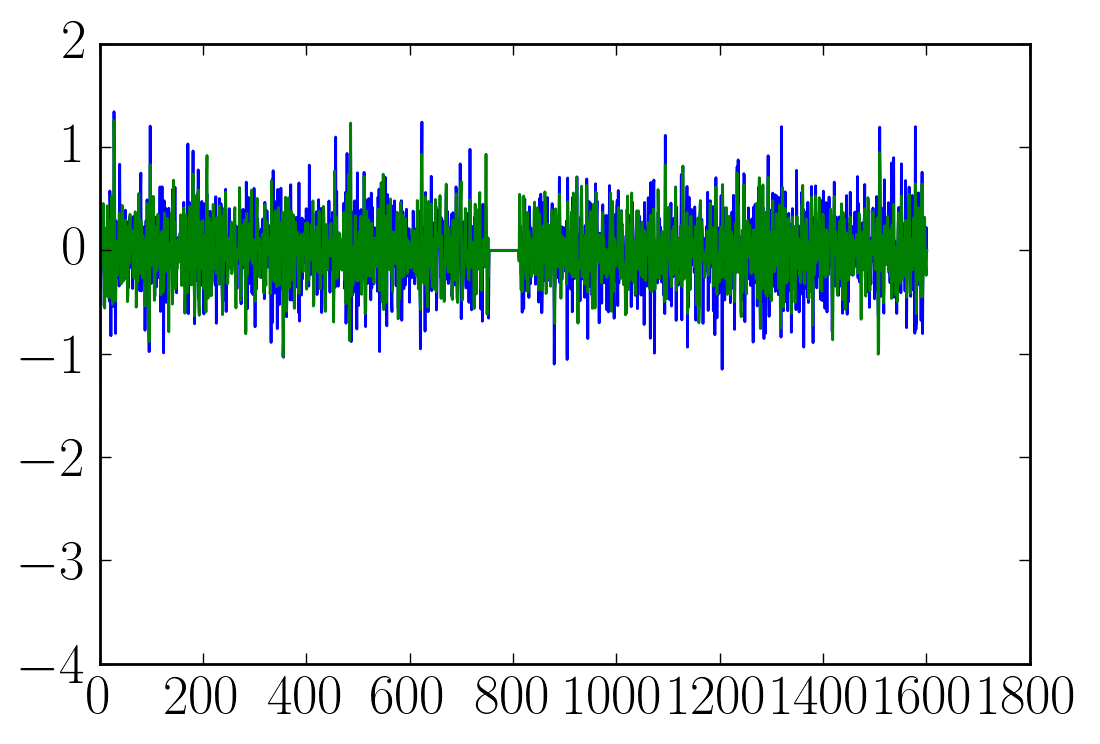

In [47]:
pl.plot(r.depth_1d)

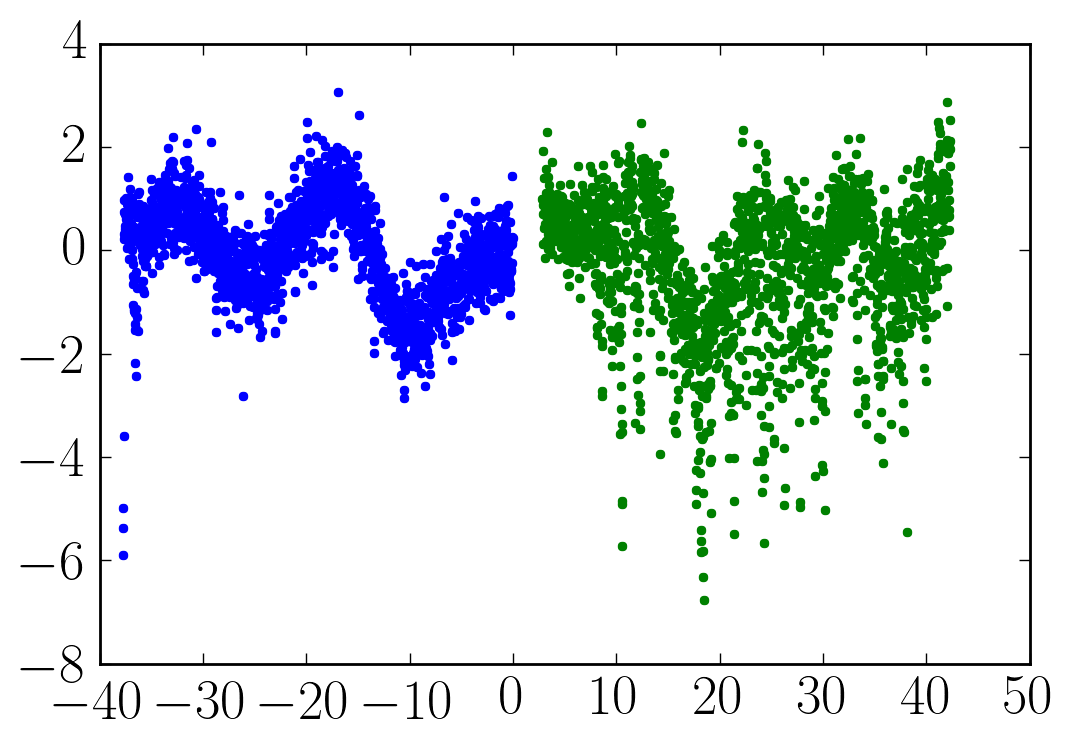

In [48]:
lcs = r.model_light_curves
[pl.plot(lc.time, lc.flux, ".") for lc in lcs];

In [49]:
r.peaks

[{'depth': 0.72080385972588612,
  'depth_ivar': 108.38185157475124,
  'duration': 0.1,
  'lnZ_box': -1470.3955253983409,
  'lnZ_none': -1496.1974025425982,
  'lnZ_outlier': -1486.2502376398941,
  'lnZ_transit': -1468.7709284032712,
  'lnZ_vee': -1475.404543510338,
  'lnlike_box': -1453.2387715256762,
  'lnlike_none': -1496.1974025425982,
  'lnlike_outlier': -1486.7226358087205,
  'lnlike_transit': -1455.4979294431168,
  'lnlike_vee': -1460.4570120260562,
  'period': 7.6172535947053372,
  'phic_same': -1841.2366429933415,
  'phic_same_second': -1850.0609156281341,
  'phic_variable': -18686.864488436451,
  's2n': 7.5040442543728663,
  't0': 1.7737191454016834,
  'transit_b': 0.48533353013114294,
  'transit_duration': 0.087286041291205527,
  'transit_period': 7.6197864099747292,
  'transit_q1': 0.50233796538062647,
  'transit_q2': 0.50067684461683881,
  'transit_ror': 0.030134668568190966,
  'transit_t0': 1.7840396261107012},
 {'depth': 0.79101677132569359,
  'depth_ivar': 38.456916142502

(0.78403962611070122, 2.784039626110701)

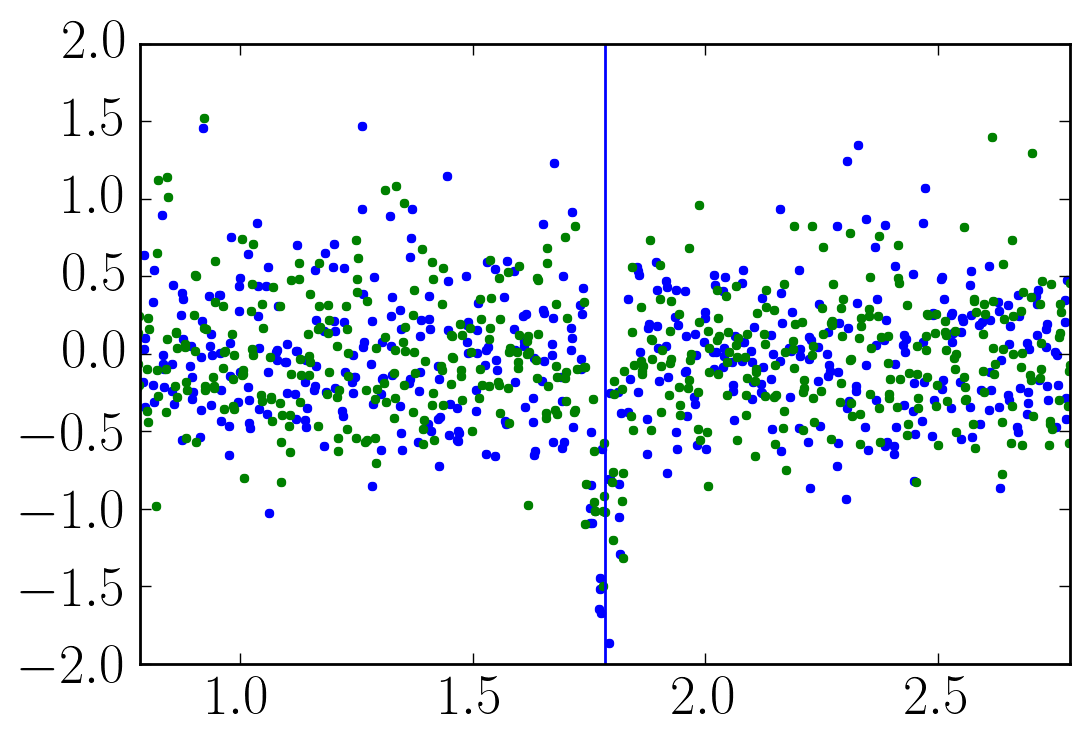

In [52]:
p = r.peaks[0]

s = SimpleSystem(period=p["transit_period"],
                 t0=p["transit_t0"],
                 ror=p["transit_ror"],
                 impact=p["transit_b"],
                 duration=p["transit_duration"],
                 q1=p["transit_q1"],
                 q2=p["transit_q2"])

mod = [1e3*(s.light_curve(lc.time)-1.0) for lc in lcs]
[pl.plot(lc.time %  p["transit_period"], lc.flux - lc.predict(lc.flux - m), ".") for lc, m in zip(lcs, mod)]
pl.gca().axvline(p["transit_t0"]);
pl.xlim(p["transit_t0"]-1, p["transit_t0"]+1)